# Prédiction des données MNIST avec uniquement 100 labels

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os

## Loading the Dataset
MNIST is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [3]:
from keras.datasets import mnist 
from keras import backend as K
from collections import Counter
(X_train_Original, Y_train_Original), (X_test_Original, Y_test_Original) = mnist.load_data()
# Counting the number of every class
EachClassSize = Counter(Y_train_Original.reshape(-1))

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
from keras.backend import clear_session
clear_session()

In [6]:
# Taking  100 Data with labels 
nber = 100 # number of labeled data
labels = [key for (key,value) in EachClassSize.items()] # take only the key of the dictionary object
idx100 = []
for i in range(len(labels)):
  idx = labels[i]==Y_train_Original
  index = np.arange(0,len(Y_train_Original))[idx]
  for j in range(10):
    idx100.append(index[j])
 

y_train100 = Y_train_Original[idx100]
x_train100 = X_train_Original[idx100]
x_train59900 = np.delete(X_train_Original,idx100,axis=0)

In [7]:
EachClassSize_test_100 = Counter(y_train100.reshape(-1))

# Part 1 - Self supervised Learning

Self supervised learning consist: 
- to work on unlabeled data
- Choose a pretexte task of classification
- Train the RotNet to learn the pretexte task

According to our article, the pretexte is to recognize the geometric transformation applied to an image that is given to the RotNet as input. 
the set of geometric transformations taken in the papers are all the image rotations by multiples of 90 degrees, i.e., 2d image rotations by
0, 90, 180, and 270 degrees. 

So, the pseudo labels will be the rotations, i.e., 0 for "0°", 1 for "90°", 2 for "180°" and 3 for "270°".



## The rotation operator

We define it as $Rot(X; d)$. It's an operator that rotates image $X$ by $d$ degrees. 

According to the article, In order to implement the image rotations by 90, 180, and 270 degrees (the 0 degrees case is the image itself), we use flip and transpose operations. Specifically 
- for 90 degrees rotation we first transpose the image and then flip it vertically (upside-down flip)
- for 180 degrees rotation we flip the image first vertically and then horizontally (left-right flip), and finally 
- for 270 degrees rotation we first flip vertically the image and then we transpose it.

In [8]:
def Rot(X, d):
  if d == 0: # 0 degrees rotation
      return X
  elif d == 90: # 90 degrees rotation
      return np.flipud(np.transpose(X))
  elif d == 180: # 180 degrees rotation
      return np.fliplr(np.flipud(X))
  elif d == 270: # 270 degrees rotation / or -90
      return np.transpose(np.flipud(X))
  else:
      raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


## Applying of the operator in the whole dataset 
We apply the foou rotation on each image on the dataset and labelled the image with the ype of rotation as define above


In [9]:
n = x_train59900.shape[0]
RotX = np.zeros([4*n,28,28])# data obtained by rotation
Roty = np.zeros(4*n)# our pseudo labels
i=0
j=0
while i < 4*n:
  if j < n:  
    RotX[i] = Rot(x_train59900[j],  0)
    RotX[i+1] = Rot(x_train59900[j],  90)
    RotX[i+2] = Rot(x_train59900[j],  180)
    RotX[i+3] = Rot(x_train59900[j],  270)
    Roty[i:i+4] = np.array([0,1,2,3])
    j = j + 1
  i = i + 4

In [10]:
n_test = X_test_Original.shape[0]
RotX_test = np.zeros([4*n_test,28,28])# data obtained by rotation
Roty_test = np.zeros(4*n_test)# our pseudo labels
i=0
j = 0
while i < 4*n_test:
  if j < n:
    RotX_test[i] = Rot(X_test_Original[j],  0)
    RotX_test[i+1] = Rot(X_test_Original[j],  90)
    RotX_test[i+2] = Rot(X_test_Original[j],  180)
    RotX_test[i+3] = Rot(X_test_Original[j],  270)
    Roty_test[i:i+4] = np.array([0,1,2,3])
    j = j + 1
  i = i+ 4

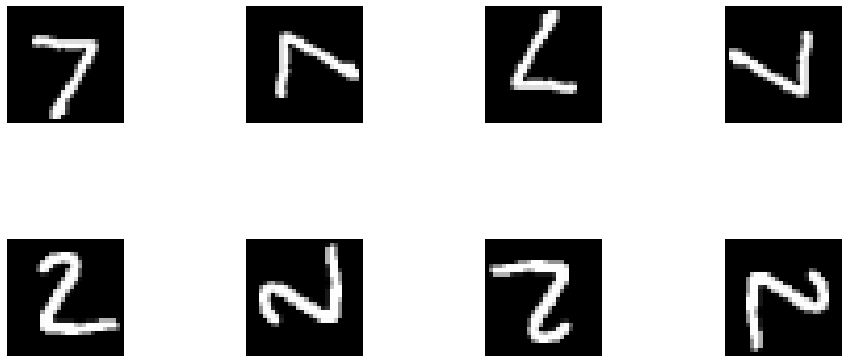

In [11]:
# verification of the rotation

import matplotlib.gridspec as gridspec
def plot(samples):
    fig = plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=1, hspace=1)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
    return

plot(RotX_test[0:8])


## Data Preprocessing 
In order to avoid overfitting, we have to apply some transformations

In [ ]:
# Splitting data
from sklearn.model_selection import train_test_split

RotX_train, RotX_val, Roty_train, Roty_val = train_test_split(
                                 RotX, Roty, 
                                 test_size = 0.2, random_state=12, 
                                 shuffle = True, stratify = Roty)

In [ ]:
Counter(list(Roty_train.reshape(-1)))


Counter({0.0: 47920, 1.0: 47920, 2.0: 47920, 3.0: 47920})

#### Convert class vectors to binary class matrices. (one-hot encoding)

In [ ]:
from keras.utils import to_categorical

In [ ]:
num_classes = np.int64(Roty.max()) +1
# Roty_val_before = Roty_val

In [ ]:
RotX_train = RotX_train.astype('float32') 
RotX_train /= 255
RotX_train = RotX_train.reshape(-1, 28,28,1)

RotX_test = RotX_test.astype('float32') 
RotX_test /= 255
RotX_test = RotX_test.reshape(-1, 28,28,1)

RotX_val = RotX_val.astype('float32')
RotX_val /= 255
RotX_val = RotX_val.reshape(-1, 28,28,1)

## Transform y in *categorial*

In [ ]:
Roty_train_before = Roty_train
Roty_test_before = Roty_test
Roty_val_before = Roty_val

In [ ]:
Roty = to_categorical(Roty, num_classes)
Roty_train = to_categorical(Roty_train, num_classes)
Roty_val = to_categorical(Roty_val, num_classes)
Roty_test = to_categorical(Roty_test, num_classes)

Conv Net

In [ ]:
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten,Conv2D, MaxPooling2D

## Building the CNN
the CNN moedel trained to recognize rotations is called here RotNet

In [ ]:
from keras.layers import Input, Flatten, Dense, ReLU, Activation, BatchNormalization, GlobalAveragePooling2D, AveragePooling2D, Reshape
from keras.models import Model,Sequential
from keras.backend import clear_session
clear_session()

## Modèle de base: **RotNet**

3 blocs de CNN.
 
Chaque bloc a 3 conv2D

In [ ]:

RotNet = Sequential()

# Convolution

#Block 1

RotNet.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1),input_shape=(28, 28,1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 160, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))
# RotNet.add(BatchNormalization())

RotNet.add(Conv2D(filters = 96, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))
# RotNet.add(BatchNormalization())

RotNet.add(MaxPooling2D(pool_size = 3, padding='same', strides=(2,2)))


# Bloc 2

RotNet.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(AveragePooling2D(pool_size = 3, padding='same', strides=(2,2)))


# Bloc 3

RotNet.add(Conv2D(filters = 192, kernel_size= 3, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))

RotNet.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
RotNet.add(BatchNormalization())
RotNet.add(Activation('relu'))



RotNet.add(GlobalAveragePooling2D())


RotNet.add(Dense(num_classes))
RotNet.add(Activation('softmax'))

In [ ]:
RotNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 192)       4800      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 192)       768       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 192)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 160)       30720     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 160)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 96)        1

## Training the RotNet RotNet

In [ ]:
from keras.optimizers import SGD

Optimizer

In [ ]:
opt = SGD(learning_rate=0.1, momentum=0.9,  nesterov=True)

In [ ]:
#Define the optimizer, the loss function and the metrics
RotNet.compile(loss='categorical_crossentropy', optimizer = opt, metrics=["accuracy"])

On fit le réseau sur les données

In [ ]:
# Démarrage de l'entrainement du réseau
hist = RotNet.fit(RotX_train, Roty_train, 
            batch_size=128,
            epochs=20,
            shuffle=True,                       # verbosité
            verbose = 1,
            validation_data=(RotX_val, Roty_val))   # données de validation (X(données) et y(labels))   

Epoch 1/20
  25/1498 [..............................] - ETA: 1:23:48 - loss: 0.8890 - accuracy: 0.5799

On trace la courbe d'apprentissage du réseau

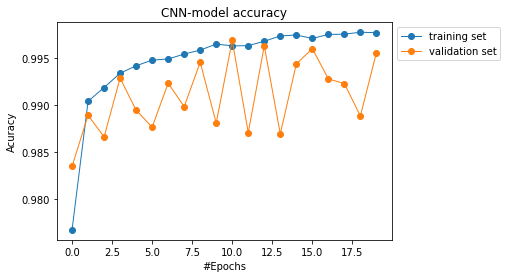

In [ ]:
plt.plot(hist.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

On trace la courbe de sa fonction de perte

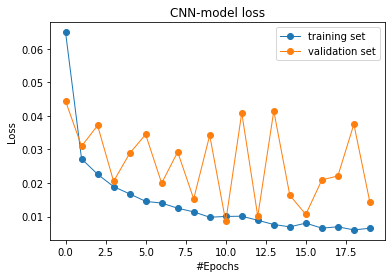

In [ ]:
plt.plot(hist.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.plot(hist.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

In [ ]:
LABELS = {
    0 : "0°", 
    1 : "90°", 
    2 : "180°", 
    3 : "270°", 
}
list(LABELS.items())

[(0, '0°'), (1, '90°'), (2, '180°'), (3, '270°')]

# Test sur les données de validations

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = RotNet.predict(RotX_val)
y_pred = np.argmax(y_pred, axis=1)
# y_true = Roty_test



In [ ]:
y_true = Roty_val_before.reshape(y_pred.shape)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_true,y_pred=y_pred)

0.9956176961602671

On fait une visualisation des prédictions des rotations sur les données de validation.

Si elle prédit mal on met une croix rouge sur l'image prédite

---



(47920, 28, 28, 1)


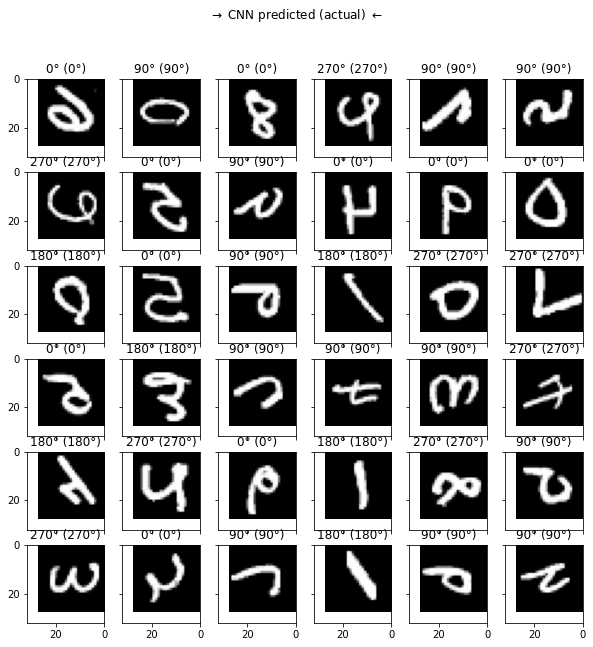

In [ ]:
# Sample test data
ix = np.random.randint(0, 10000, size=36)
ex_im = RotX_val[ix]
ex_lb = Roty_val[ix]
print(RotX_val.shape)
# Predict
out = RotNet.predict(ex_im) #RotNet
classes = np.argmax(out, axis=1)  # softmax output -> class

# Plot
fig, axes = plt.subplots(6, 6, figsize=(10, 10), sharey=True, sharex=True);
fig.suptitle(r'$\rightarrow$ CNN predicted (actual) $\leftarrow$')

k = 0
for i in range(6):
    for j in range(6):
        # Switch Axes
        ax = axes[i, j]
        
        # Show image
        ax.imshow(ex_im[k].reshape(28, 28), cmap='Greys_r');
        
        # Determine labels
        actual_lab = LABELS[np.argmax(ex_lb[k])]
        pred_lab = LABELS[classes[k]]
        
        # Format title
        title = "{} ({})".format(pred_lab, actual_lab)
        title_color = 'black'
        
        # Mark image if wrong prediction
        if actual_lab != pred_lab:
            ax.plot(np.array([0, 32]), np.array([0, 32]), 'r-')
            ax.plot(np.array([0, 32]), np.array([32, 0]), 'r-')
            title_color = 'red'

        # Set title
        ax.set_title(title, color=title_color);
        
        # Set limits
        ax.set_xlim(32, 0)
        ax.set_ylim(32, 0)
            
        k += 1

# Test sur les données test



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = RotNet.predict(RotX_test)
y_pred = np.argmax(y_pred, axis=1)


In [ ]:
y_true = Roty_test_before.reshape(y_pred.shape)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_true,y_pred=y_pred)

0.9948

On fait une visualisation des prédictions des rotations sur les données de test.

Si elle prédit mal on met une croix rouge sur l'image prédite


In [ ]:
# Sample test data
nb_data = 8
ix = np.random.randint(0, 10000, size=nb_data*nb_data)
ex_im = RotX_test[ix]
ex_lb = Roty_test[ix]
print(RotX_val.shape)
# Predict
out = RotNet.predict(ex_im) #RotNet
classes = np.argmax(out, axis=1)  # softmax output -> class

# Plot
fig, axes = plt.subplots(nb_data, nb_data, figsize=(10, 10), sharey=True, sharex=True);
fig.suptitle(r'$\rightarrow$ CNN predicted (actual) $\leftarrow$')

k = 0
for i in range(nb_data):
    for j in range(nb_data):
        # Switch Axes
        ax = axes[i, j]
        
        # Show image
        ax.imshow(ex_im[k].reshape(28, 28), cmap='Greys_r');
        
        # Determine labels
        actual_lab = LABELS[np.argmax(ex_lb[k])]
        pred_lab = LABELS[classes[k]]
        
        # Format title
        title = "{} ({})".format(pred_lab, actual_lab)
        title_color = 'black'
        
        # Mark image if wrong prediction
        if actual_lab != pred_lab:
            ax.plot(np.array([0, 32]), np.array([0, 32]), 'r-')
            ax.plot(np.array([0, 32]), np.array([32, 0]), 'r-')
            title_color = 'red'

        # Set title
        ax.set_title(title, color=title_color);
        
        # Set limits
        ax.set_xlim(32, 0)
        ax.set_ylim(32, 0)
            
        k += 1

In [ ]:
scores = RotNet.evaluate(RotX_test, Roty_test, batch_size=128)

In [ ]:
scores

[0.015339497476816177, 0.9947999715805054]

# Géler certaines parties

On fait une copie du modèle créé en haut

In [ ]:
model_frozen = RotNet


In [ ]:
model_frozen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 192)       4800      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 192)       768       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 192)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 160)       30720     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 160)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 96)        1

# Gèle des layers

Les deux premiers blocs sont gélés

Les poids reste modifiable à partir du dernier et troisième bloc.

Les vingt premières couches correspondent au deux premiers blocs de notre modèle de base

In [ ]:
for layer in model_frozen.layers[:20]:
    layer.trainable=False
    
for layer in model_frozen.layers[20:]:
    layer.trainable=True

In [ ]:
num_classes2 = np.int64(y_train100.max()) +1

In [ ]:
model_frozen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 192)       4800      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 192)       768       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 192)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 160)       30720     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 160)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 96)        1

ON choisit la sortie de la 4 ème dernière couche en partant de la dernière couche.

Cette couche corresponde à la dernière couche avant les couches de classification. Les sorties de cette couche sont les caractéristiques de l'image.

Ensuite le Global average pooling nous permet pour récupérer les poids des couches gélées.

Puis on on ajoute une couche Dense(10, activation="softmax") pour la prédiction de nos 10 classes (0,1,...,9)


In [ ]:
X= model_frozen.layers[-4].output
InputMod = tf.keras.Input(shape=(28, 28, 1))
globalAv = GlobalAveragePooling2D()(X)
predictions = Dense(num_classes2, activation="softmax")(globalAv)
model_final = tf.keras.Model(model_frozen.input,predictions)

Optimizer du modèle final

In [ ]:
from keras.optimizers import Adam
opt2 = SGD(learning_rate=0.1, momentum=0.9,  nesterov=True)

epochs = 50
learning_rate = 0.0005
decay_rate = learning_rate/epochs

opt2 = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

In [ ]:
model_final.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=["accuracy"])

On normalise les données train et on fait une copie des données y originales

In [ ]:
x_train100_2 = x_train100.astype('float32') 
x_train100_2 /= 255
x_train100_2 = x_train100_2.reshape(-1, 28,28,1)

y_train100_before = y_train100


On transforme en categorial y_train100

In [ ]:
y_train100_2 = to_categorical(y_train100, num_classes2)

On fit le modèle final sur les 100 données.

In [ ]:
hist2 = model_final.fit(x_train100_2, y_train100_2, 
            batch_size = 10,
            epochs=20,
            shuffle=True,                       # verbosité
            verbose = 1,
            )

Epoch 1/20
10/10 [==============================] - 1s 5ms/step - loss: 2.5092 - accuracy: 0.1375
Epoch 2/20
10/10 [==============================] - 0s 5ms/step - loss: 2.0893 - accuracy: 0.2960
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 1.9159 - accuracy: 0.5618
Epoch 4/20
10/10 [==============================] - 0s 5ms/step - loss: 1.6873 - accuracy: 0.7958
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 1.4646 - accuracy: 0.8253
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 1.3134 - accuracy: 0.8300
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 1.0714 - accuracy: 0.9239
Epoch 8/20
10/10 [==============================] - 0s 4ms/step - loss: 0.9007 - accuracy: 0.9223
Epoch 9/20
10/10 [==============================] - 0s 4ms/step - loss: 0.7300 - accuracy: 0.8934
Epoch 10/20
10/10 [==============================] - 0s 3ms/step - loss: 0.5730 - accuracy: 0.9717
Epoch 11/20
10/10 [

On trace les courbes d'apprentissage et de fonction de perte

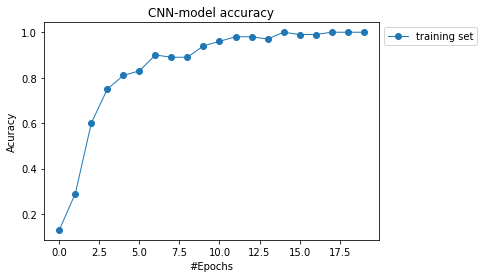

In [ ]:
plt.plot(hist2.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
# plt.plot(hist2.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

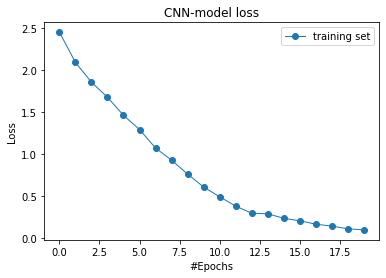

In [ ]:
plt.plot(hist2.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
# plt.plot(hist2.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

In [ ]:
y_pred = model_final.predict(x_train100_2)
y_pred = np.argmax(y_pred, axis=1)



In [ ]:
LABELS2 = {
    0 : "0", 
    1 : "1", 
    2 : "2", 
    3 : "3", 
    4 : "4",           
    5 : "5", 
    6 : "6",
    7 : "7", 
    8 : "8",
    9 : "9"
}

# On fait le test sur des données train 100

In [ ]:
y_true = y_train100_before.reshape(y_pred.shape)


### Accuracy

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true=y_true,y_pred=y_pred)

0.99

# On fait le test sur les données test

In [ ]:
X_test = X_test_Original.astype('float32') 
X_test /= 255
X_test = X_test.reshape(-1, 28,28,1)


## Accuracy sur les données test

In [ ]:
y_pred3 = model_final.predict(X_test)
y_pred3 = np.argmax(y_pred3, axis=1)



In [ ]:
y_true3 = Y_test_Original.reshape(y_pred3.shape)

In [ ]:
accuracy_score(y_true=y_true3,y_pred=y_pred3)

0.8787

In [ ]:
y_test = to_categorical(Y_test_Original, num_classes2)

In [ ]:
scores = model_final.evaluate(X_test, y_test, batch_size=128)

79/79 [==============================] - 1s 13ms/step - loss: 0.6069 - accuracy: 0.8787


In [ ]:
scores[1]

0.8787000179290771

# Modèle supervisé

On crée ici un modèle avec la même architecture que notre modèle finale.

Mais cette fois on n'appliquera pas de transformations géométriques pour essayer de récupérer les caractéristiques de l'image.

Le but est de comparer ce modèle à notre modèle semi-supervisé

In [13]:
clear_session()

In [ ]:

baseline = Sequential()

# Convolution

#Block 1

baseline.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1),input_shape=(28, 28,1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))

baseline.add(Conv2D(filters = 160, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(Conv2D(filters = 96, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(MaxPooling2D(pool_size = 3, padding='same', strides=(2,2)))

# Bloc 2

baseline.add(Conv2D(filters = 192, kernel_size= 5, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(AveragePooling2D(pool_size = 3, padding='same', strides=(2,2)))
# baseline.add(MaxPooling2D(pool_size = 3, strides=(2,2)))

# Bloc 3

baseline.add(Conv2D(filters = 192, kernel_size= 3, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(Conv2D(filters = 192, kernel_size= 1, use_bias=False, padding='same', strides=(1, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
# baseline.add(BatchNormalization())

baseline.add(GlobalAveragePooling2D())
# baseline.add(Dropout(0.6))


# baseline.add(Flatten())
baseline.add(Dense(num_classes2))
baseline.add(Activation('softmax'))

In [ ]:
baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 192)       4800      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 192)       768       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 192)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 160)       30720     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 160)       640       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 96)        1

In [ ]:
baseline.compile(loss='categorical_crossentropy', optimizer=opt2, metrics=["accuracy"])

In [ ]:
hist3 = baseline.fit(x_train100_2, y_train100_2, 
            batch_size=50,
            epochs=10,
            shuffle=True,                       # verbosité
            verbose = 1,
            )

Epoch 1/10
2/2 [==============================] - 1s 20ms/step - loss: 2.3433 - accuracy: 0.1333
Epoch 2/10
2/2 [==============================] - 0s 20ms/step - loss: 1.7073 - accuracy: 0.6000
Epoch 3/10
2/2 [==============================] - 0s 20ms/step - loss: 1.1556 - accuracy: 0.7867
Epoch 4/10
2/2 [==============================] - 0s 20ms/step - loss: 0.7823 - accuracy: 0.9400
Epoch 5/10
2/2 [==============================] - 0s 20ms/step - loss: 0.5264 - accuracy: 0.9667
Epoch 6/10
2/2 [==============================] - 0s 20ms/step - loss: 0.3241 - accuracy: 0.9867
Epoch 7/10
2/2 [==============================] - 0s 20ms/step - loss: 0.2074 - accuracy: 0.9867
Epoch 8/10
2/2 [==============================] - 0s 20ms/step - loss: 0.1382 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 20ms/step - loss: 0.0882 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 21ms/step - loss: 0.0569 - accuracy: 1.0000


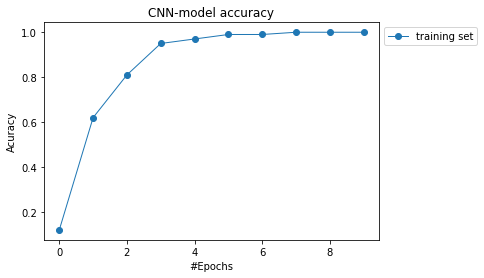

In [ ]:
plt.plot(hist3.history['accuracy'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
# plt.plot(hist2.history['val_accuracy'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model accuracy")
plt.xlabel('#Epochs')
plt.ylabel('Acuracy')
plt.legend(bbox_to_anchor=( 1., 1.))

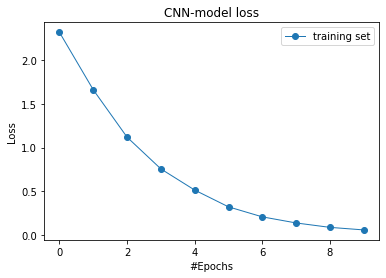

In [ ]:
plt.plot(hist3.history['loss'], label='training set',marker='o', linestyle='solid',linewidth=1, markersize=6)
# plt.plot(hist2.history['val_loss'], label='validation set',marker='o', linestyle='solid',linewidth=1, markersize=6)
plt.title("CNN-model loss")
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=( 1., 1.))

#### Accuracy sur les données test

In [ ]:
y_pred5 = baseline.predict(X_test)
y_pred5 = np.argmax(y_pred5, axis=1)


In [ ]:
y_true5 = Y_test_Original.reshape(y_pred5.shape)

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [ ]:
accuracy_score(y_true=y_true5,y_pred=y_pred5)

0.1137

On remarque un overfitting du modèle pendant l'apprentissage mais le test sur des données test donne de mauvais résultats

In [ ]:
scores = baseline.evaluate(X_test, y_test, batch_size=128)

79/79 [==============================] - 1s 13ms/step - loss: 2.3122 - accuracy: 0.1137


In [ ]:
scores

[2.312241315841675, 0.1137000024318695]